# Framework
1. Analyse Lyrics - Bert based, Hatebert, senwave bert
2. Analyse beat - Tempo, rhythm, chord, key, structure, spectral, loudness, visualizations
3. Participant section - 

In [138]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from collections import Counter
from nltk.util import ngrams
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertForSequenceClassification, BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt



In [139]:
nltk.download('punkt')
nltk.download('stopwords')
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lyric Analysis - Kanye

In [140]:
df = pd.DataFrame(columns=["song_title", "song_lyrics"])

In [141]:
def censor_words(tokens):  # renamed 'text' to 'tokens' to be clearer
    word_censor = {
        "nigga": "n*gga",
        "nigger": "n*gger",
        "anal": "@n@l",
        "booty": "b**ty",
        "pussy": "p*ssy",
        "sex": "s*x",
        "niggas": "n*ggas"
    }
    return [word_censor.get(word, word) for word in tokens]

def clean_lyrics(text, include_labels=False):
    if include_labels:
        text = re.sub(r"(?<!\[)[\"'(),{}\]?](?!])", "", text)
    else:
        text = re.sub(r"\[.*?\]", "", text)
        text = re.sub(r"[\"'(),\[\]{}?]", "", text)

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = censor_words(tokens)  # Assuming you defined this elsewhere

    return tokens

In [142]:
def create_ngram_df(lyrics, artist):
    ngram_df = pd.DataFrame(columns=["ngram", "freq", "ngram_type"])
    bigram = Counter(list(ngrams(lyrics, 2)))
    trigram = Counter(list(ngrams(lyrics, 3)))
    for bi, freq in bigram.items():
        ngram_df = pd.concat([pd.DataFrame([[bi, freq, "bigram"]], columns=ngram_df.columns), ngram_df], ignore_index=True)
    for tri, freq in trigram.items():
        ngram_df = pd.concat([pd.DataFrame([[tri, freq, "trigram"]], columns=ngram_df.columns), ngram_df], ignore_index=True)
    ngram_df['artist'] =  artist
    return ngram_df

In [143]:
def get_top_ngrams(df):
    top_10_bigrams = df[df['ngram_type'] == "bigram"].sort_values("freq", ascending=False).head(10)
    top_10_trigrams = df[df['ngram_type'] == "trigram"].sort_values("freq", ascending=False).head(10)
    return top_10_bigrams, top_10_trigrams

# Lyric Analysis - Cardi B

In [144]:
def read_lyrics(artists=["kanye", "cardib", "elton", "tom"]):
    lyrics = {}
    for i, artist in enumerate(artists, start=1):
        with open(f"./song{i}/lyrics.txt", "r", encoding="utf-8") as f:
            contents = f.read()
        lyrics[artist] = contents
    return lyrics



def create_df():
    res = pd.DataFrame(columns=["ngram", "freq", "ngram_type", "artist"])
    artist_lyrics = read_lyrics()
    for artist, lyric in artist_lyrics.items():
        ngram_df = create_ngram_df(clean_lyrics(lyric), artist)
        res = pd.concat([res, ngram_df], ignore_index=True)
        
    return res


In [145]:
ngram_df = create_df() # concatenate the songs into one df

In [146]:
ngram_df

,ngram,freq,ngram_type,artist
0,"(hands, n*gga, heil)",1,trigram,kanye
1,"(her, hands, n*gga)",1,trigram,kanye
2,"(in, her, hands)",1,trigram,kanye
3,"(world, in, her)",1,trigram,kanye
4,"(the, world, in)",1,trigram,kanye
...,...,...,...,...
3128,"(guilty, for)",1,bigram,tom
3129,"(feel, guilty)",1,bigram,tom
3130,"(not, feel)",1,bigram,tom
3131,"(can, not)",1,bigram,tom


In [147]:
ngram_df['rank'] = ngram_df.groupby(['ngram_type', 'artist'])['freq'].rank(method="first", ascending=False)
top_ngrams = ngram_df[ngram_df['rank'] <= 10].drop(columns="rank")

In [148]:
top_ngrams


,ngram,freq,ngram_type,artist
29,"(nazis, n*gga, heil)",3,trigram,kanye
30,"(n*ggas, nazis, n*gga)",3,trigram,kanye
31,"(my, n*ggas, nazis)",3,trigram,kanye
32,"(hitler, all, my)",3,trigram,kanye
33,"(heil, hitler, all)",3,trigram,kanye
...,...,...,...,...
2948,"(dear, white)",4,bigram,tom
2949,"(boy, dear)",4,bigram,tom
2950,"(black, white)",4,bigram,tom
2965,"(white, boy)",23,bigram,tom


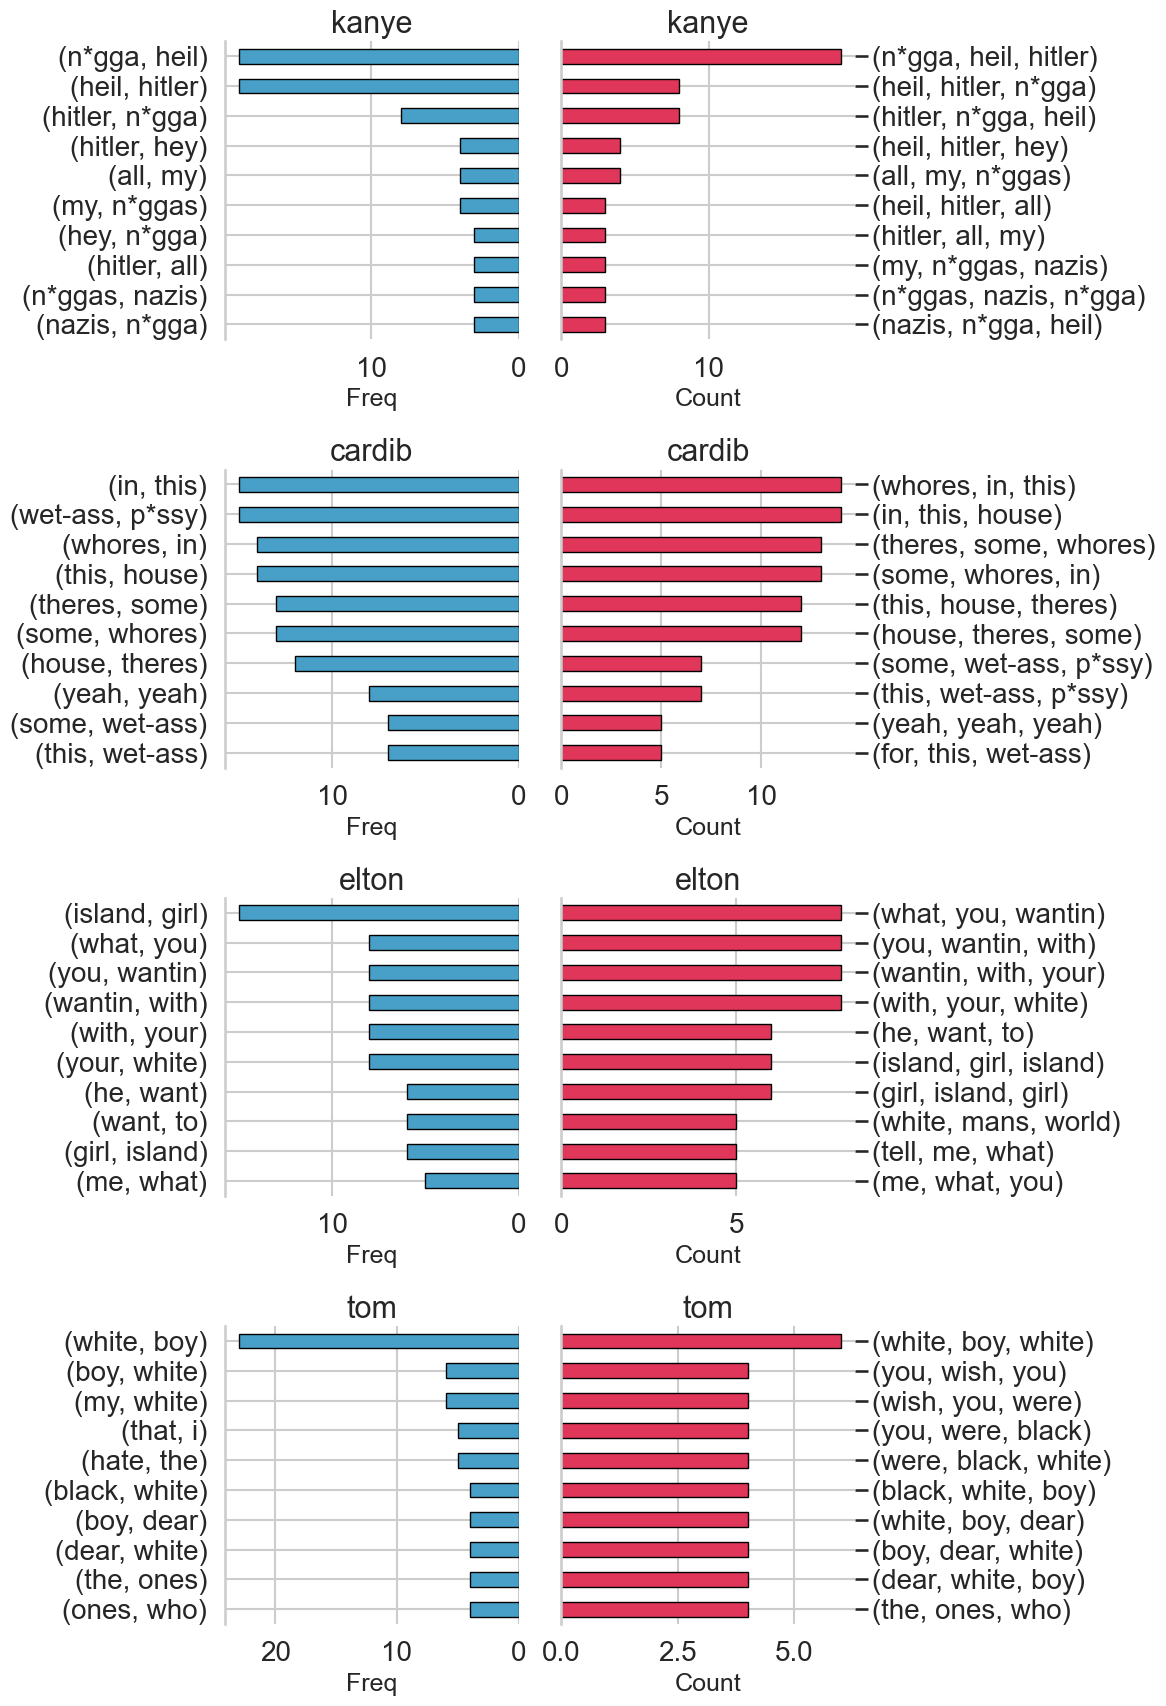

In [149]:
categories = top_ngrams['artist'].unique()

fig, axes = plt.subplots(len(categories), 2, figsize=(12, 5 * len(categories)), 
                         gridspec_kw={'width_ratios': [1, 1]})

if len(categories) == 1:
    axes = [axes]

for idx, category in enumerate(categories):
    bigram_df = top_ngrams[top_ngrams['ngram_type'] == "bigram"]
    trigram_df = top_ngrams[top_ngrams['ngram_type'] == "trigram"]

    group = bigram_df[bigram_df['artist'] == category]
    
    trigram_group = trigram_df[trigram_df['artist'] == category]
    
    # plot bigram data 
    group.sort_values('freq', ascending=True).plot.barh(
        x='ngram', y='freq', ax=axes[idx][0], color=barcolors[3], legend=False, **barstyle)
    axes[idx][0].set_xlabel("Freq")
    axes[idx][0].set_ylabel('', fontsize=25)
    axes[idx][0].invert_xaxis()  
    axes[idx][0].tick_params(axis='both', labelsize=20)
    axes[idx][0].set_title(f"{category}", fontsize=22)

    # plot trigram data
    trigram_group.sort_values('freq', ascending=True).plot.barh(
        x='ngram', y='freq', ax=axes[idx][1], color=barcolors[6], legend=False, **barstyle)
    axes[idx][1].set_xlabel("Count")
    axes[idx][1].set_ylabel('', fontsize=25)
    axes[idx][1].yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
    axes[idx][1].tick_params(axis='both', labelsize=20)
    axes[idx][1].set_title(f"{category}", fontsize=22)
    sns.despine(bottom=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

## Hatebert

In [150]:
def preprocess_lines(lyrics):
    
    lines = lyrics.split("\n")
    lines = [x for x in lines if x != ""]
    return lines

In [151]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")
model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain")

In [152]:
def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class




In [153]:
from transformers import pipeline
sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [155]:
# DistilBERT base uncased finetuned SST-2
line_sentiment = pd.DataFrame(columns=["line", "sentiment", "section", "artist"])
artist_lyric = read_lyrics().items()
for artist, lyric in artist_lyric:
    current_section = None
    for line in preprocess_lines(lyric):
        if line.startswith("[") and line.endswith("]"):
            raw_section = line.strip("[]").strip()
            lower = raw_section.lower()

            # Use regex to match general section types
            if re.match(r"^verse(\b|:)", lower):         # e.g., "Verse", "Verse 2", "Verse: Artist"
                current_section = "Verse"
            elif re.match(r"^(post-)?chorus(\b|:)", lower):  # e.g., "Chorus", "Post-Chorus", "Chorus: Ye"
                current_section = "Chorus"
            elif re.match(r"^intro(\b|:)", lower):       # e.g., "Intro", "Intro: Artist"
                current_section = "Intro"
            elif re.match(r"^bridge(\b|:)", lower):
                current_section = "Bridge"
            elif re.match(r"^outro(\b|:)", lower):
                current_section = "Outro"
            else:
                current_section = None  # Unrecognized section, skip
            continue  # Skip the section label line itself

        if current_section is None:
            continue  # Skip lines not under a valid section

        s = 1 if sentiment(line)[0]['label'] == "NEGATIVE" else 0
        row = pd.DataFrame([[line, s, current_section, artist]], columns=line_sentiment.columns)
        line_sentiment = pd.concat([line_sentiment, row], ignore_index=True)

In [156]:
line_sentiment

,line,sentiment,section,artist
0,"Man, these people took my kids from me, then t...",1,Verse,kanye
1,"I got so much anger in me, got no way to take ...",1,Verse,kanye
2,"Think I'm stuck in The Matrix, where the fuck'...",1,Verse,kanye
3,"Yes, I am a cuck, I like when people fuck on m...",0,Verse,kanye
4,"The shit that I'm posting on Twitter, they tel...",1,Verse,kanye
...,...,...,...,...
235,Don't tell me how to see it through my white eyes,1,Chorus,tom
236,"White boy, don't say that",1,Chorus,tom
237,"White boy, oh, you so bad",1,Chorus,tom
238,"White boy, you wish you were black",1,Chorus,tom


In [157]:
line_sentiment['line_number'] = line_sentiment.groupby("artist").cumcount()+1

In [158]:
line_sentiment

,line,sentiment,section,artist,line_number
0,"Man, these people took my kids from me, then t...",1,Verse,kanye,1
1,"I got so much anger in me, got no way to take ...",1,Verse,kanye,2
2,"Think I'm stuck in The Matrix, where the fuck'...",1,Verse,kanye,3
3,"Yes, I am a cuck, I like when people fuck on m...",0,Verse,kanye,4
4,"The shit that I'm posting on Twitter, they tel...",1,Verse,kanye,5
...,...,...,...,...,...
235,Don't tell me how to see it through my white eyes,1,Chorus,tom,88
236,"White boy, don't say that",1,Chorus,tom,89
237,"White boy, oh, you so bad",1,Chorus,tom,90
238,"White boy, you wish you were black",1,Chorus,tom,91


In [159]:
line_sentiment.to_csv("./data/lines.csv")

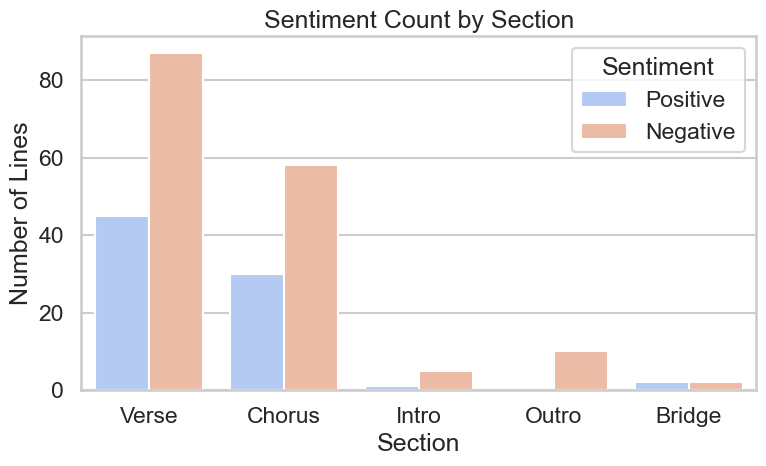

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=line_sentiment, x="section", hue="sentiment", palette="coolwarm")
plt.title("Sentiment Count by Section")
plt.xlabel("Section")
plt.ylabel("Number of Lines")
plt.legend(title="Sentiment", labels=["Positive", "Negative"])
plt.tight_layout()
plt.show()

C:\Users\jiyon\AppData\Local\Temp\ipykernel_8828\2337686706.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neg_proportion.values, y=neg_proportion.index, palette="Reds_r")


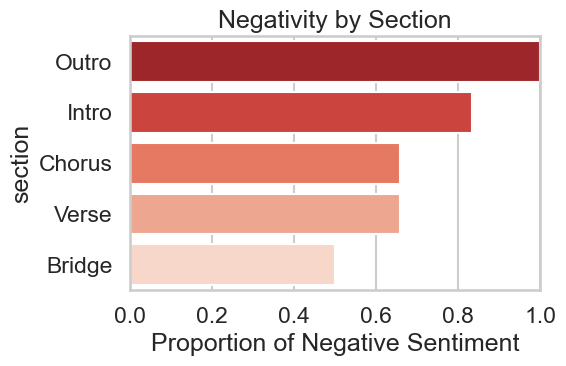

In [ ]:
neg_proportion = line_sentiment.groupby("section")["sentiment"].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=neg_proportion.values, y=neg_proportion.index, palette="Reds_r")
plt.xlabel("Proportion of Negative Sentiment")
plt.title("Negativity by Section")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

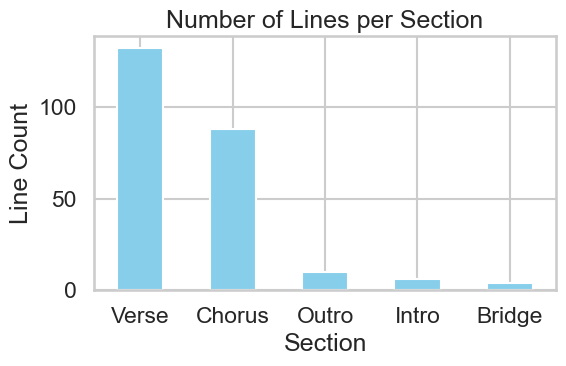

In [ ]:
plt.figure(figsize=(6, 4))
line_sentiment["section"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Number of Lines per Section")
plt.xlabel("Section")
plt.ylabel("Line Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
